# Results report

This notebook summarizes the results obtained from the current model versus the baseline providing quantitative and qualitative results

## Comparison with the baseline [Uncertainty-Aware CNNs for Depth Completion: Uncertainty from Beginning to End](https://arxiv.org/abs/2006.03349)

### Area Under the Curve

In [1]:
import torch
from lidar_confidence.metrics import percentiles
from lidar_confidence.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import sys
import os
from pathlib import Path
import warnings
from tqdm import tqdm
import json
from tabulate import tabulate
from collections import defaultdict
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np

sys.path.append(str(Path("../experiments/baselines/ncnn/models")))

In [2]:
with open(Path("../results/lce/lce.json"), "rt") as f:
    model_results = json.load(f)

ncnn_baselines_names = [
    "ncnn_conf_l1",
    "ncnn_conf_l1_kitti_limited",
    "ncnn_conf_l2",
    "ncnn_conf_l2_kitti_limited",
    "pncnn_exp",
    "pncnn_exp_kitti_limited",
    "pncnn",
    "pncnn_kitti_limited",
]
    
ncnn_baselines = {}
for file_path in [f"../results/baselines/{name}.json" for name in ncnn_baselines_names]:
    with open(Path(file_path), "rt") as f:
        name = Path(file_path).name.split(".")[0]
        ncnn_baselines[name] = json.load(f)   

headers = ["name", "test_1/auc_mae", "test_1/auc_rmse", "test_2/auc_mae", "test_2/auc_rmse"]
lines = []
lines.append(["ours", *[model_results[f] for f in headers[1:]]])
for name in ncnn_baselines:
    lines.append([name, *[ncnn_baselines[name][f] for f in headers[1:]]])

print("AUC METRICS\n")
print(tabulate(lines, headers=headers))

AUC METRICS

name                          test_1/auc_mae    test_1/auc_rmse    test_2/auc_mae    test_2/auc_rmse
--------------------------  ----------------  -----------------  ----------------  -----------------
ours                               0.0339743           0.129176         0.0375919           0.198499
ncnn_conf_l1                       0.0366265           0.168196         0.0499436           0.34795
ncnn_conf_l1_kitti_limited         0.038377            0.153022         0.0501595           0.309279
ncnn_conf_l2                       0.0813635           0.52002          0.126445            0.922411
ncnn_conf_l2_kitti_limited         0.0732701           0.46235          0.1079              0.832891
pncnn_exp                          0.0794808           0.475819         0.112293            0.854729
pncnn_exp_kitti_limited            0.106918            0.813116         0.180837            1.54304
pncnn                              0.0907495           0.484447         0.127313

### RMSE removing the less confident measures

In [3]:
def transform(d):
    for k in d:
        d[k] = F.to_tensor(d[k])
    d["img"] = F.normalize(d["img"], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return d

ds_split_142 = Dataset("../data/dataset", transform=transform, split="test_2")
dl_split_142 = DataLoader(ds_split_142)

model = torch.jit.load("../results/lce/model.pth").to("cuda")

baselines = {}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for baseline_name in ncnn_baselines_names:
        sys.path.append(str(Path(f"../experiments/baselines/ncnn/models/{baseline_name}")))
        baselines[baseline_name] = (
            torch.load(f"../experiments/baselines/ncnn/models/{baseline_name}/model.pth", map_location="cuda")["model"]
        )

In [4]:
thresholds = [100, 95, 90, 80, 70, 60, 50, 40, 30, 20]

def compute_error(lidar, gt, conf_mask, depth_mask=None):
    
    if depth_mask is None:
        mask = (lidar > 0) & (gt > 0)
    else:
        mask = depth_mask
        
    lidar_, gt_ = lidar[mask][conf_mask], gt[mask][conf_mask]
    err = torch.sqrt(torch.mean(torch.square(lidar_ - gt_)))
    return err

errs = defaultdict(lambda: [])
for batch in tqdm(dl_split_142):
    mask = (batch["lidar"] > 0) & (batch["gt"] > 0)
    
    with torch.no_grad():
        std = model(torch.cat([batch["img"].to("cuda"), batch["lidar"].to("cuda")], 1)).cpu()[mask]
        
        base_confs = {}
        for name, base_model in baselines.items():
            base_confs[name] = base_model(batch["lidar"].to("cuda"))[:, 2:].cpu()[mask]
        
    mine_err = []
    for perc in thresholds:
        percentile = percentiles(std, [perc])[0, 0]
        mine_err.append(compute_error(batch["lidar"], batch["gt"], std <= percentile))
    errs["our"].append(mine_err)
    
    for name in baselines:
        base_err = []
        for perc in thresholds:
            percentile = percentiles(base_confs[name], [100 - perc])[0, 0]
            base_err.append(compute_error(batch["lidar"], batch["gt"], base_confs[name] >= percentile))
        errs[name].append(base_err)
        
lines = []
for key in errs:
    lines.append([key, *map(lambda x: x.item(), torch.tensor(errs[key]).mean(axis=0))])

  0%|          | 0/142 [00:00<?, ?it/s]

  1%|          | 1/142 [00:00<02:09,  1.09it/s]

  1%|▏         | 2/142 [00:01<01:39,  1.41it/s]

  2%|▏         | 3/142 [00:02<01:30,  1.53it/s]

  3%|▎         | 4/142 [00:02<01:23,  1.64it/s]

  4%|▎         | 5/142 [00:03<01:20,  1.71it/s]

  4%|▍         | 6/142 [00:03<01:18,  1.74it/s]

  5%|▍         | 7/142 [00:04<01:16,  1.76it/s]

  6%|▌         | 8/142 [00:04<01:15,  1.77it/s]

  6%|▋         | 9/142 [00:05<01:13,  1.81it/s]

  7%|▋         | 10/142 [00:05<01:12,  1.83it/s]

  8%|▊         | 11/142 [00:06<01:10,  1.85it/s]

  8%|▊         | 12/142 [00:06<01:10,  1.86it/s]

  9%|▉         | 13/142 [00:07<01:09,  1.86it/s]

 10%|▉         | 14/142 [00:07<01:08,  1.87it/s]

 11%|█         | 15/142 [00:08<01:07,  1.88it/s]

 11%|█▏        | 16/142 [00:09<01:06,  1.89it/s]

 12%|█▏        | 17/142 [00:09<01:06,  1.89it/s]

 13%|█▎        | 18/142 [00:10<01:06,  1.87it/s]

 13%|█▎        | 19/142 [00:10<01:05,  1.87it/s]

 14%|█▍        | 20/142 [00:11<01:04,  1.90it/s]

 15%|█▍        | 21/142 [00:11<01:03,  1.89it/s]

 15%|█▌        | 22/142 [00:12<00:59,  2.02it/s]

 16%|█▌        | 23/142 [00:12<00:55,  2.13it/s]

 17%|█▋        | 24/142 [00:12<00:53,  2.22it/s]

 18%|█▊        | 25/142 [00:13<00:51,  2.28it/s]

 18%|█▊        | 26/142 [00:13<00:49,  2.33it/s]

 19%|█▉        | 27/142 [00:14<00:48,  2.37it/s]

 20%|█▉        | 28/142 [00:14<00:47,  2.40it/s]

 20%|██        | 29/142 [00:14<00:46,  2.42it/s]

 21%|██        | 30/142 [00:15<00:46,  2.43it/s]

 22%|██▏       | 31/142 [00:15<00:45,  2.45it/s]

 23%|██▎       | 32/142 [00:16<00:44,  2.47it/s]

 23%|██▎       | 33/142 [00:16<00:43,  2.48it/s]

 24%|██▍       | 34/142 [00:16<00:43,  2.49it/s]

 25%|██▍       | 35/142 [00:17<00:42,  2.51it/s]

 25%|██▌       | 36/142 [00:17<00:42,  2.51it/s]

 26%|██▌       | 37/142 [00:18<00:41,  2.52it/s]

 27%|██▋       | 38/142 [00:18<00:40,  2.54it/s]

 27%|██▋       | 39/142 [00:18<00:41,  2.49it/s]

 28%|██▊       | 40/142 [00:19<00:41,  2.45it/s]

 29%|██▉       | 41/142 [00:19<00:41,  2.44it/s]

 30%|██▉       | 42/142 [00:20<00:41,  2.41it/s]

 30%|███       | 43/142 [00:20<00:41,  2.41it/s]

 31%|███       | 44/142 [00:21<00:40,  2.40it/s]

 32%|███▏      | 45/142 [00:21<00:39,  2.44it/s]

 32%|███▏      | 46/142 [00:21<00:39,  2.44it/s]

 33%|███▎      | 47/142 [00:22<00:39,  2.43it/s]

 34%|███▍      | 48/142 [00:22<00:38,  2.42it/s]

 35%|███▍      | 49/142 [00:23<00:38,  2.40it/s]

 35%|███▌      | 50/142 [00:23<00:38,  2.38it/s]

 36%|███▌      | 51/142 [00:23<00:38,  2.36it/s]

 37%|███▋      | 52/142 [00:24<00:38,  2.36it/s]

 37%|███▋      | 53/142 [00:24<00:37,  2.37it/s]

 38%|███▊      | 54/142 [00:25<00:36,  2.39it/s]

 39%|███▊      | 55/142 [00:25<00:36,  2.40it/s]

 39%|███▉      | 56/142 [00:26<00:35,  2.43it/s]

 40%|████      | 57/142 [00:26<00:34,  2.48it/s]

 41%|████      | 58/142 [00:26<00:33,  2.49it/s]

 42%|████▏     | 59/142 [00:27<00:33,  2.50it/s]

 42%|████▏     | 60/142 [00:27<00:32,  2.52it/s]

 43%|████▎     | 61/142 [00:27<00:32,  2.53it/s]

 44%|████▎     | 62/142 [00:28<00:31,  2.53it/s]

 44%|████▍     | 63/142 [00:28<00:31,  2.53it/s]

 45%|████▌     | 64/142 [00:29<00:30,  2.53it/s]

 46%|████▌     | 65/142 [00:29<00:30,  2.54it/s]

 46%|████▋     | 66/142 [00:29<00:30,  2.52it/s]

 47%|████▋     | 67/142 [00:30<00:30,  2.49it/s]

 48%|████▊     | 68/142 [00:30<00:29,  2.48it/s]

 49%|████▊     | 69/142 [00:31<00:29,  2.48it/s]

 49%|████▉     | 70/142 [00:31<00:29,  2.47it/s]

 50%|█████     | 71/142 [00:32<00:28,  2.45it/s]

 51%|█████     | 72/142 [00:32<00:28,  2.44it/s]

 51%|█████▏    | 73/142 [00:32<00:28,  2.46it/s]

 52%|█████▏    | 74/142 [00:33<00:27,  2.47it/s]

 53%|█████▎    | 75/142 [00:33<00:26,  2.52it/s]

 54%|█████▎    | 76/142 [00:34<00:25,  2.54it/s]

 54%|█████▍    | 77/142 [00:34<00:25,  2.53it/s]

 55%|█████▍    | 78/142 [00:34<00:25,  2.52it/s]

 56%|█████▌    | 79/142 [00:35<00:25,  2.51it/s]

 56%|█████▋    | 80/142 [00:35<00:25,  2.45it/s]

 57%|█████▋    | 81/142 [00:36<00:25,  2.43it/s]

 58%|█████▊    | 82/142 [00:36<00:24,  2.45it/s]

 58%|█████▊    | 83/142 [00:36<00:24,  2.43it/s]

 59%|█████▉    | 84/142 [00:37<00:23,  2.46it/s]

 60%|█████▉    | 85/142 [00:37<00:23,  2.47it/s]

 61%|██████    | 86/142 [00:38<00:22,  2.45it/s]

 61%|██████▏   | 87/142 [00:38<00:22,  2.45it/s]

 62%|██████▏   | 88/142 [00:38<00:22,  2.44it/s]

 63%|██████▎   | 89/142 [00:39<00:21,  2.44it/s]

 63%|██████▎   | 90/142 [00:39<00:21,  2.43it/s]

 64%|██████▍   | 91/142 [00:40<00:21,  2.43it/s]

 65%|██████▍   | 92/142 [00:40<00:20,  2.43it/s]

 65%|██████▌   | 93/142 [00:40<00:20,  2.45it/s]

 66%|██████▌   | 94/142 [00:41<00:19,  2.43it/s]

 67%|██████▋   | 95/142 [00:41<00:19,  2.43it/s]

 68%|██████▊   | 96/142 [00:42<00:19,  2.41it/s]

 68%|██████▊   | 97/142 [00:42<00:18,  2.40it/s]

 69%|██████▉   | 98/142 [00:43<00:18,  2.40it/s]

 70%|██████▉   | 99/142 [00:43<00:17,  2.40it/s]

 70%|███████   | 100/142 [00:43<00:17,  2.44it/s]

 71%|███████   | 101/142 [00:44<00:16,  2.47it/s]

 72%|███████▏  | 102/142 [00:44<00:16,  2.49it/s]

 73%|███████▎  | 103/142 [00:45<00:15,  2.50it/s]

 73%|███████▎  | 104/142 [00:45<00:15,  2.49it/s]

 74%|███████▍  | 105/142 [00:45<00:14,  2.48it/s]

 75%|███████▍  | 106/142 [00:46<00:14,  2.48it/s]

 75%|███████▌  | 107/142 [00:46<00:14,  2.46it/s]

 76%|███████▌  | 108/142 [00:47<00:13,  2.47it/s]

 77%|███████▋  | 109/142 [00:47<00:13,  2.44it/s]

 77%|███████▋  | 110/142 [00:47<00:13,  2.43it/s]

 78%|███████▊  | 111/142 [00:48<00:12,  2.42it/s]

 79%|███████▉  | 112/142 [00:48<00:12,  2.45it/s]

 80%|███████▉  | 113/142 [00:49<00:11,  2.44it/s]

 80%|████████  | 114/142 [00:49<00:11,  2.43it/s]

 81%|████████  | 115/142 [00:49<00:11,  2.42it/s]

 82%|████████▏ | 116/142 [00:50<00:10,  2.41it/s]

 82%|████████▏ | 117/142 [00:50<00:10,  2.41it/s]

 83%|████████▎ | 118/142 [00:51<00:09,  2.40it/s]

 84%|████████▍ | 119/142 [00:51<00:09,  2.41it/s]

 85%|████████▍ | 120/142 [00:52<00:09,  2.43it/s]

 85%|████████▌ | 121/142 [00:52<00:08,  2.40it/s]

 86%|████████▌ | 122/142 [00:52<00:08,  2.40it/s]

 87%|████████▋ | 123/142 [00:53<00:07,  2.42it/s]

 87%|████████▋ | 124/142 [00:53<00:07,  2.51it/s]

 88%|████████▊ | 125/142 [00:54<00:06,  2.50it/s]

 89%|████████▊ | 126/142 [00:54<00:06,  2.52it/s]

 89%|████████▉ | 127/142 [00:54<00:05,  2.50it/s]

 90%|█████████ | 128/142 [00:55<00:05,  2.48it/s]

 91%|█████████ | 129/142 [00:55<00:05,  2.48it/s]

 92%|█████████▏| 130/142 [00:56<00:04,  2.47it/s]

 92%|█████████▏| 131/142 [00:56<00:04,  2.46it/s]

 93%|█████████▎| 132/142 [00:56<00:04,  2.44it/s]

 94%|█████████▎| 133/142 [00:57<00:03,  2.42it/s]

 94%|█████████▍| 134/142 [00:57<00:03,  2.42it/s]

 95%|█████████▌| 135/142 [00:58<00:02,  2.42it/s]

 96%|█████████▌| 136/142 [00:58<00:02,  2.46it/s]

 96%|█████████▋| 137/142 [00:58<00:02,  2.45it/s]

 97%|█████████▋| 138/142 [00:59<00:01,  2.45it/s]

 98%|█████████▊| 139/142 [00:59<00:01,  2.46it/s]

 99%|█████████▊| 140/142 [01:00<00:00,  2.46it/s]

 99%|█████████▉| 141/142 [01:00<00:00,  2.51it/s]

100%|██████████| 142/142 [01:00<00:00,  2.48it/s]

100%|██████████| 142/142 [01:00<00:00,  2.33it/s]

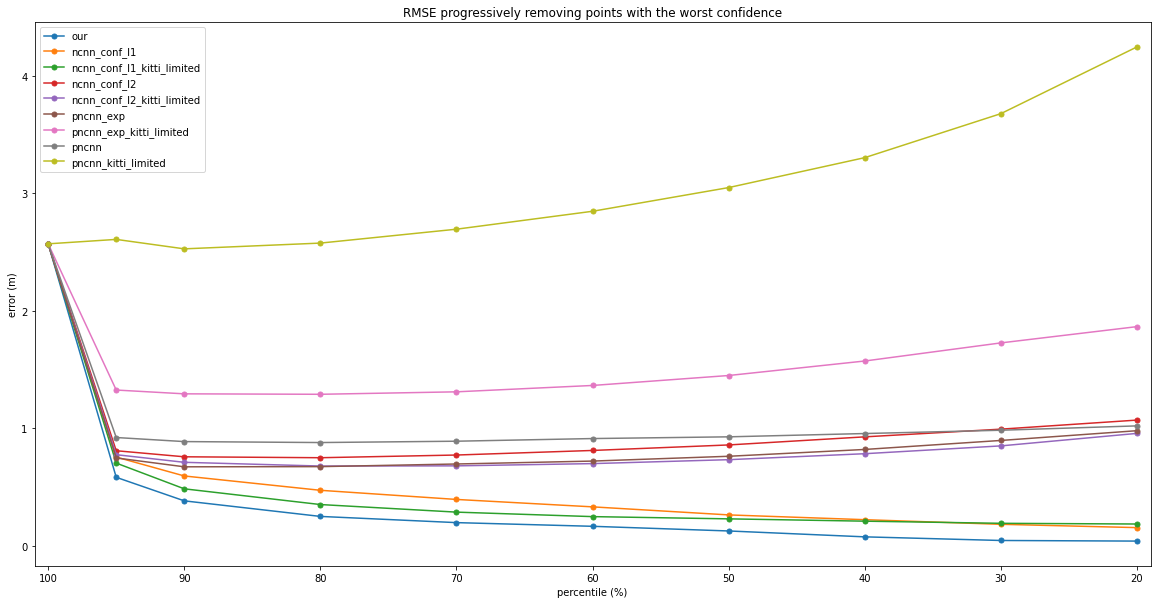

In [5]:
plt.figure(figsize=(20, 10))
plt.title("RMSE progressively removing points with the worst confidence")
plt.gca().set_xlim(left=101, right=19)
plt.gca().set_xlabel("percentile (%)")
plt.gca().set_ylabel("error (m)")

for line in lines:
    plt.plot(thresholds, line[1:], label=line[0], markersize=10, marker=".")

plt.legend()
plt.show()

And finally below an image of the points removed by our method

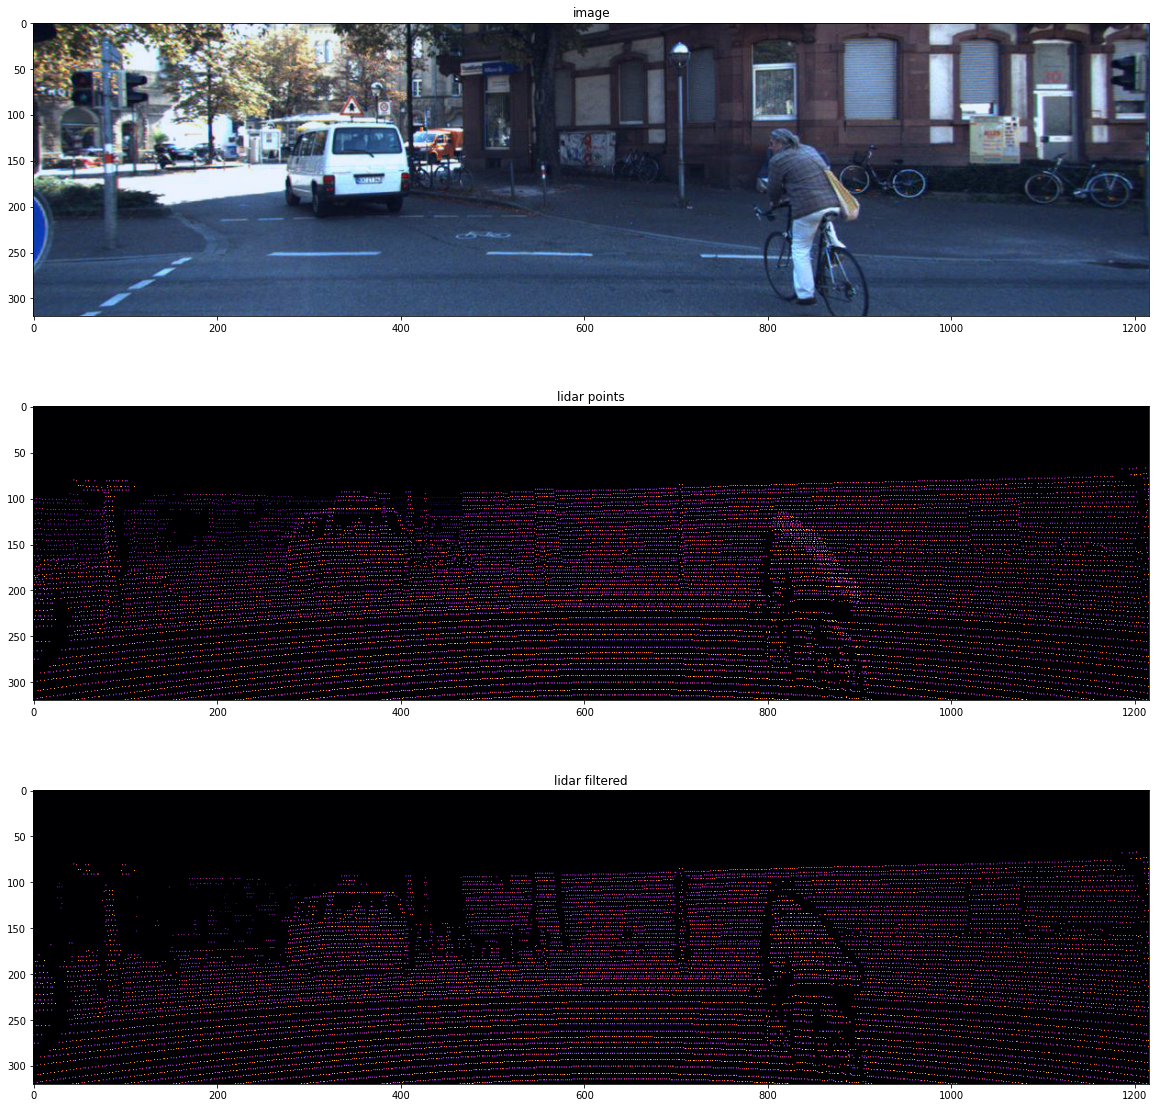

In [6]:
dl_iter = iter(dl_split_142)
for i in range(1):
    batch = next(dl_iter)
    
def depth_imshow(depth):
    depth = depth.clone()
    depth[depth > 0] = depth.max() - depth[depth > 0]
    plt.imshow(depth, cmap="inferno")

def normalize(img):
    return (img - img.min()) / (img.max() - img.min())
    
mask = batch["lidar"] > 0
with torch.no_grad():
    std = model(torch.cat([batch["img"].to("cuda"), batch["lidar"].to("cuda")], 1)).cpu()
    percentile = percentiles(std[mask], [85])[0, 0]
    mask_ = mask & (std <= percentile)

plt.figure(figsize=(20, 20))
plt.subplot(3, 1, 1); plt.title("image"); plt.imshow(normalize(batch["img"])[0].permute(1, 2, 0))
plt.subplot(3, 1, 2); plt.title("lidar points"); depth_imshow(batch["lidar"][0, 0])
plt.subplot(3, 1, 3); plt.title("lidar filtered"); depth_imshow(torch.where(
    mask_, batch["lidar"], torch.tensor(0.)
)[0, 0])
plt.show()

## Comparison with [A Surface Geometry Model for LiDAR Depth Completion](https://arxiv.org/pdf/2104.08466.pdf)

This paper provides a way to compute a binary mask to remove outliers thus AUC based metrics are not useful

In [7]:
def compute_error(lidar, gt, conf_mask, depth_mask=None):
    
    if depth_mask is None:
        mask = (lidar > 0) & (gt > 0)
    else:
        mask = depth_mask
        
    lidar_, gt_ = lidar[mask][conf_mask], gt[mask][conf_mask]
    err = torch.sqrt(torch.mean(torch.square(lidar_ - gt_)))
    return err

# prepare data

def transform(d):
    for k in d:
        d[k] = F.to_tensor(d[k])
    d["img"] = F.normalize(d["img"], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return d

class DatasetWithMasks(torch.utils.data.Dataset):
    
    def __init__(self, split):
        self.ds = Dataset("../data/dataset", split=split)
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, x):
        batch = self.ds[x]
        
        idx = str(x).zfill(10)
        batch["baseline_mask"] = np.array(
            Image.open(Path(f"../experiments/baselines/surface_geometry_model/{split}_masks/{idx}.png"))
        )[..., None]
        batch["baseline_mask"] = batch["baseline_mask"] / 256
        batch["baseline_mask"] = batch["baseline_mask"].astype(bool)
        
        return transform(batch)
    
for split in ["test_1", "test_2"]:
    print(f"\n== on {split} == ")
    ds = DatasetWithMasks(split)
    dl = DataLoader(ds)

    # compute the error
    error_100 = []
    error_filtered = []
    removed_perc = []
    for batch in dl:
        mask = (batch["lidar"] > 0) & (batch["gt"] > 0)
        error_100.append(torch.sqrt(torch.mean(torch.square(batch["lidar"][mask] - batch["gt"][mask]))))

        orig_mask_num = mask.sum()
        mask = mask & batch["baseline_mask"]
        filtered_mask_num = mask.sum()
        removed_perc.append(filtered_mask_num / orig_mask_num)

        error_filtered.append(torch.sqrt(torch.mean(torch.square(batch["lidar"][mask] - batch["gt"][mask]))))

    error_100 = torch.stack(error_100).mean().item()
    error_filtered = torch.stack(error_filtered).mean().item()
    removed_perc = 100 - torch.stack(removed_perc).mean().item() * 100
    print("Error before filtering: {:3.5f} m".format(error_100))
    print("Error after filtering:  {:3.5f} m".format(error_filtered))
    print("% of removed measures:  {:3.5f} %".format(removed_perc))

    error = []
    for batch in dl:
        mask = (batch["lidar"] > 0) & (batch["gt"] > 0)

        with torch.no_grad():
            std = model(torch.cat([batch["img"].to("cuda"), batch["lidar"].to("cuda")], 1)).cpu()[mask]

        percentile = percentiles(std, [100 - removed_perc])[0, 0]
        error.append(compute_error(batch["lidar"], batch["gt"], std <= percentile))

    error = torch.stack(error).mean().item()
    print("\nOur error removing {:3.5f} %: {:3.5f} m".format(removed_perc, error))


== on test_1 == 


Error before filtering: 1.59525 m
Error after filtering:  0.68543 m
% of removed measures:  1.60476 %



Our error removing 1.60476 %: 0.70562 m

== on test_2 == 


Error before filtering: 2.56984 m
Error after filtering:  1.41893 m
% of removed measures:  1.47263 %



Our error removing 1.47263 %: 1.18890 m
